# Image Colourization Machine Learning Algorithm
This notebook utilizes the Tensorflow library to impolement an AutoEncoder which converts landscape images from black and white to RGB.

In [3]:
#Necessary libraries are imported here
import numpy as np 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
print(tf.__version__)

2.1.0


In [4]:
#Here we check is GPU is available for training or not Or whether the tensorflow version can utilize gpu 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())

Number of GPUs : 1
Tensorflow GPU : True


In [7]:
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

# Data Cleaning
In the next cell we create a numpy array of all the filenames and their paths.
After that we use the Python Imaging Library to check for corrupted images and remove them from the file list

In [8]:
fileList=[]
fl=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fileList.append(os.path.join(dirname, filename))
for i in fileList:
    if i.endswith('.jpg'):
        fl.append(i)
fileList=np.array(fl)

In [9]:
from PIL import Image
fl=[]
for filename in fileList:
    
    try:
      img = Image.open(filename)# open the image file
      img.verify() # verify that it is, in fact an image
      fl.append(filename)
    except Exception:
        print("Bad File",filename)
fileList=np.array(fl)
np.random.shuffle(fileList)

Bad File /kaggle/input/landscape-pictures/00000120 (6).jpg
Bad File /kaggle/input/landscape-pictures/00000249 (6).jpg
Bad File /kaggle/input/landscape-pictures/landscape/00000120 (6).jpg
Bad File /kaggle/input/landscape-pictures/landscape/00000249 (6).jpg


# Creating an Input PipeLine for the model
Here we utilize the Tensorflow Dataset api to create a flexible input pipeline for the model

In [10]:
#The image size is kept at 400 x 400,
#and also we normalize the input image data so that each pixel value lies in 0~1 range
IMG_SIZE=(256,256)
batch=1
def decode_img(x):
    x=tf.io.read_file(x)
    x=tf.image.decode_jpeg(x,channels=3)
    x=tf.image.resize(x,IMG_SIZE)
    return x

def rgb_to_gs(x):
    gs = tf.image.rgb_to_grayscale(x)
    gs=tf.math.divide(gs,255)
    return gs


def create_dataset(filename_list):
    df=tf.data.Dataset.from_tensor_slices(filename_list)
    im=df.map(decode_img)
    gs=im.map(rgb_to_gs)
    df=tf.data.Dataset.zip((gs,im))
    df=df.batch(batch)
    df=df.prefetch(tf.data.experimental.AUTOTUNE)
    return df
#These are the actual objects representing the input pipeline for Training and Testing
train_df=create_dataset(fileList[:int(len(fileList)*0.8)])
test_df=create_dataset(fileList[int(len(fileList)*0.8):])

# Model Creation 
In the next cell we utilize the sequential api of keras to create a model capable of coloring B&W images.

In [11]:
from tensorflow.keras.layers import Input,Conv2D,Add,Conv2DTranspose
ip=Input(shape=(256, 256,1))
x=Conv2D(128,5,padding='same',activation='relu')(ip)
x1=Conv2D(32,1,padding='same',activation='relu')(x)
x2=Conv2D(32,3,padding='same',activation='relu')(x)
x2=Conv2D(32,3,padding='same',activation='relu')(x2)


x=Add()([x2,x1])
x11=Conv2D(32,1,padding='same',activation='relu')(x)
x21=Conv2D(32,3,padding='same',activation='relu')(x)
x21=Conv2D(32,3,padding='same',activation='relu')(x21)
x=Add()([x21,x11])
x11=Conv2D(32,1,padding='same',activation='relu')(x)
x21=Conv2D(32,3,padding='same',activation='relu')(x)
x21=Conv2D(32,3,padding='same',activation='relu')(x21)
x=Add()([x21,x11])
x11=Conv2D(32,1,padding='same',activation='relu')(x)
x21=Conv2D(32,3,padding='same',activation='relu')(x)
x21=Conv2D(32,3,padding='same',activation='relu')(x21)
x=Add()([x21,x11])

x=Conv2DTranspose(32,3,padding='same',activation='relu')(x)
x=Add()([x,x11])
x=Conv2DTranspose(32,3,padding='same',activation='relu')(x)

x=Add()([x,x1])
x=Conv2DTranspose(32,5,padding='same',activation='relu')(x)

x=Add()([x,x1])
x=Conv2DTranspose(64,7,padding='same',activation='relu')(x)
x=Conv2DTranspose(16,7,padding='same',activation='relu')(x)
x=Conv2DTranspose(64,7,padding='same',activation='relu')(x)
x=Conv2DTranspose(16,7,padding='same',activation='relu')(x)
x=Conv2DTranspose(3,7,padding='same')(x)
model=Model(inputs=ip,outputs=x)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss ='MSE')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 128 3328        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 36896       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_2[0][0]                   
______________________________________________________________________________________________

# Training the model
Here we train the model for 15 epochs 

In [12]:
with tf.device(device):
    model.fit(train_df,
            validation_data=test_df,
              epochs=15)

Train for 6910 steps, validate for 1728 steps
Epoch 1/15
6910/6910 [==============================] - 349s 51ms/step - loss: 1152.1139 - val_loss: 885.8351
Epoch 2/15
6910/6910 [==============================] - 345s 50ms/step - loss: 839.3298 - val_loss: 752.8813
Epoch 3/15
6910/6910 [==============================] - 345s 50ms/step - loss: 740.0633 - val_loss: 683.7684
Epoch 4/15
6910/6910 [==============================] - 345s 50ms/step - loss: 694.4865 - val_loss: 680.5850
Epoch 5/15
6910/6910 [==============================] - 345s 50ms/step - loss: 663.3949 - val_loss: 634.2874
Epoch 6/15
6910/6910 [==============================] - 349s 50ms/step - loss: 641.3083 - val_loss: 673.5789
Epoch 7/15
6910/6910 [==============================] - 347s 50ms/step - loss: 629.3936 - val_loss: 617.0303
Epoch 8/15
6910/6910 [==============================] - 347s 50ms/step - loss: 621.9572 - val_loss: 601.7288
Epoch 9/15
6910/6910 [==============================] - 347s 50ms/step - loss: 61

# Saving the model

In [13]:
model.save("ImageColourizationTFV2_256x256.h5")

# Looking at Training Results 
Here we isolate a batch of test data and use it to see how well our model performs on real world data.

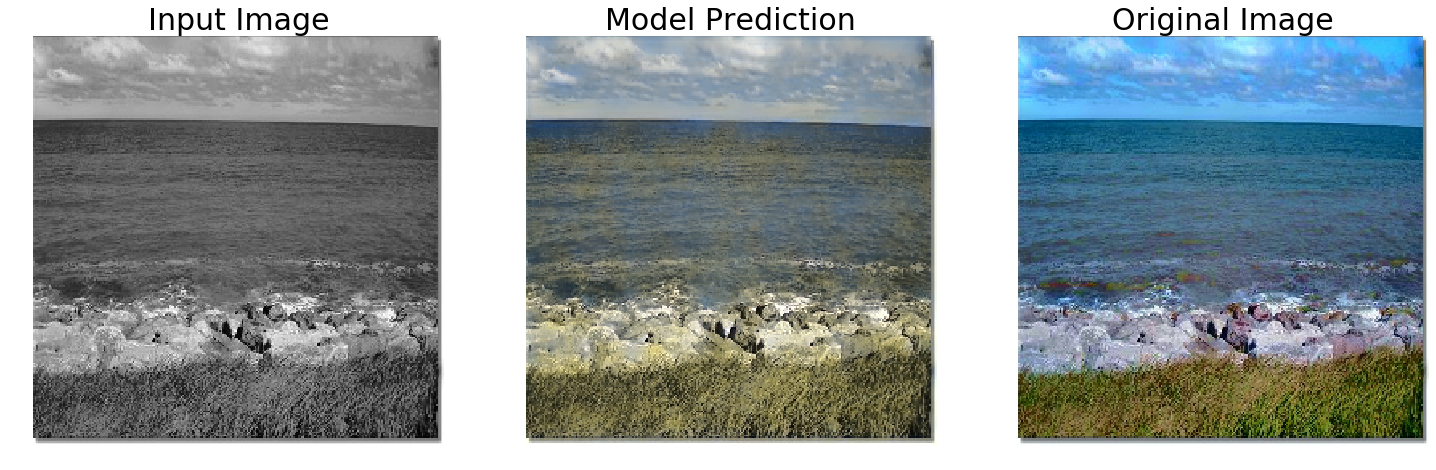

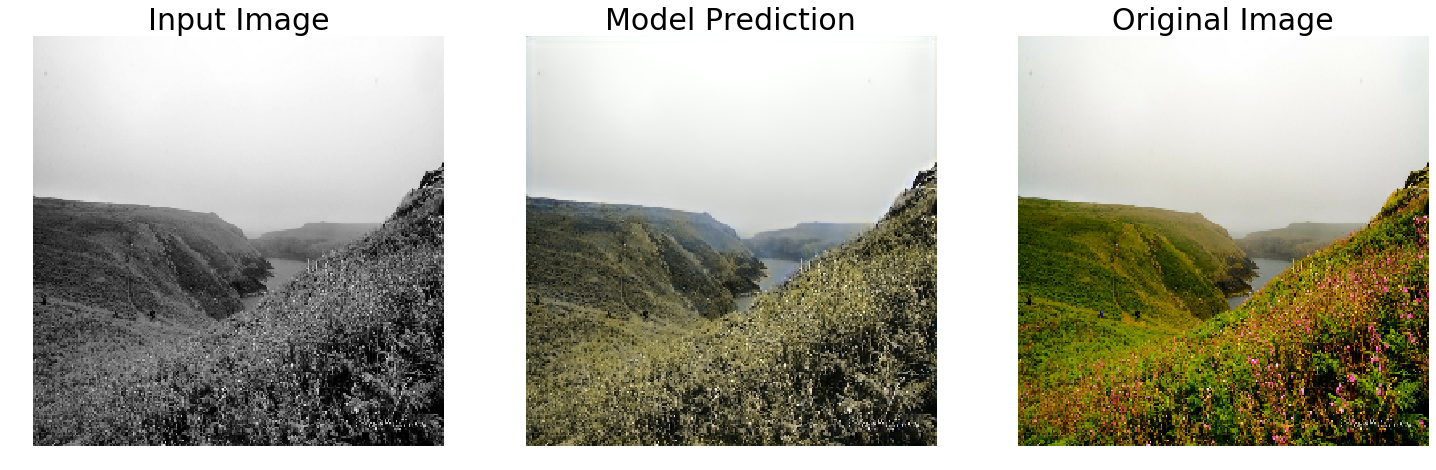

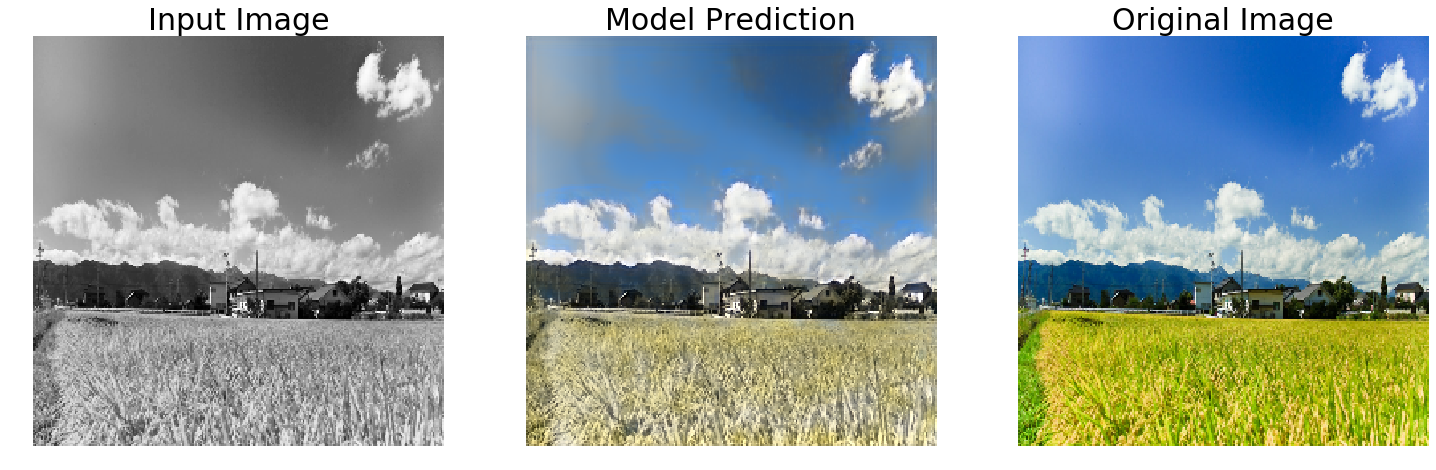

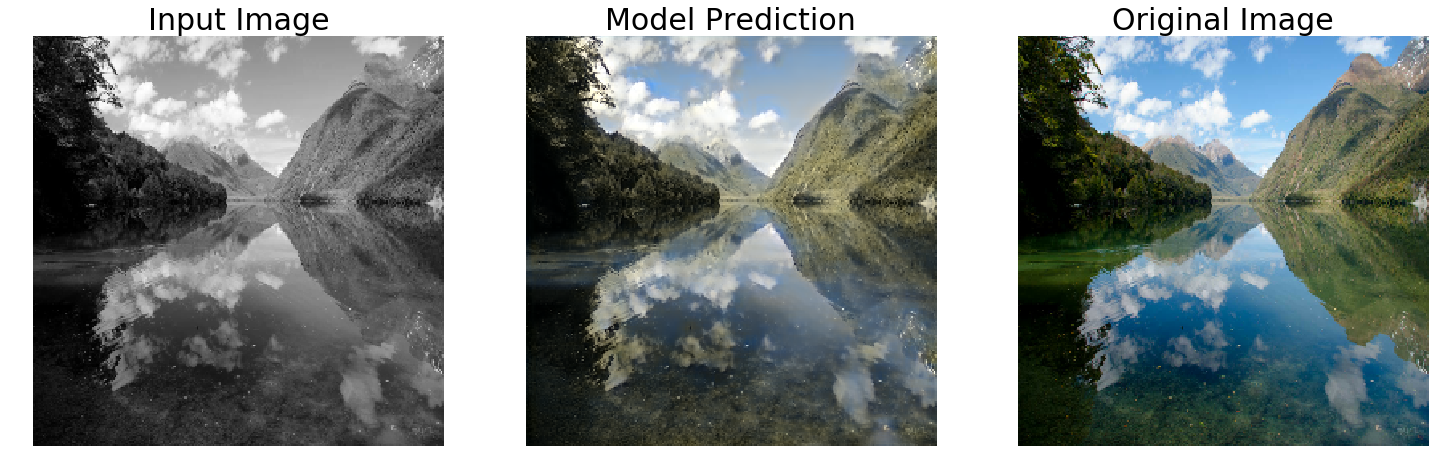

In [20]:
ds_iter=iter(test_df)
for im_no in range(4):
    fig,axis=plt.subplots(1,3,figsize=(25, 80))
    x,y=next(ds_iter)
    yhat=model.predict(x)
    axis[0].imshow(x.numpy().reshape(256,256),cmap='gray')
    axis[0].axis('off')
    axis[0].set_title("Input Image", fontsize=30)
    axis[1].imshow(np.array(yhat[0],dtype=int).astype(int))
    axis[1].axis('off')
    axis[1].set_title("Model Prediction", fontsize=30)
    axis[2].imshow(np.array(y[0]).astype(int))
    axis[2].axis('off')
    axis[2].set_title("Original Image", fontsize=30)